In [1]:
#NBVAL_IGNORE_OUTPUT
# Adding ignore due to (probably an np notebook magic) bug
import numpy as np
%matplotlib inline
from devito import *
from examples.seismic.source import RickerSource, Receiver, TimeAxis
from examples.seismic import plot_image, plot_velocity, plot_perturbation, demo_model, ModelElastic
# from examples.seismic.model import SeismicModel
from sympy import init_printing, latex
from anisotropy import StiffnessMatrix, Rotator, StiffnessMatrixVTI
init_printing(use_latex='mathjax')

import matplotlib.pyplot as plt

In [2]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import plot_velocity
from examples.seismic.Zom.model_stiffness import Model, SeismicModel

so = 2 # this could work
so = 6 # this will lead to "nan".   !!!!!!!!!!!!!!!!!!!!!!!!!!!
to = 2

# Define a physical size
shape = (150, 300, 100) # Number of grid point (nx, nz)
spacing = (10., 10., 10.)  # Grid spacing in m. 
# The domain size is now 1500m * 3000m * 1000m. 

interface = 35 # The basement starts at 350m.

dtype = np.float32

origin = (0, 0, 0) 

In [3]:
vp = np.zeros(shape) 
vp[:,:,:interface] = 1.5
vp[:,:,interface:] = .5

vs = np.zeros(shape) 
vs[:,:,:interface]= .8
vs[:,:,interface:]= .3

buo = np.zeros(shape)
buo[:,:,:interface] = 1/1.7
buo[:,:,interface:] = 1/2.7

nbl = 20


In [4]:
# Define our 'upper' and 'lower' SubDomains:
class Upper(SubDomain):
    name = 'upper'
    def define(self, dimensions):
        x, y, z = dimensions
        return {x: x, y: y, z: ('left', interface+nbl)}
    
class Lower(SubDomain):
    name = 'lower'
    def define(self, dimensions):
        x, y, z = dimensions
        return {x: x, y: y, z: ('right', shape[2]+nbl-interface)}

# Create these subdomains:
ur = Upper()
lr = Lower()

In [5]:
model = ModelElastic(space_order=so, vp=vp, vs=vs, b=buo, origin=origin, shape=shape,
                     spacing=spacing, nbl=nbl, subdomains=(ur,lr))

Operator `initdamp` run in 0.02 s
Operator `pad_lam` run in 0.01 s
Operator `pad_mu` run in 0.01 s
Operator `pad_b` run in 0.01 s


In [6]:
stiffnessMat = StiffnessMatrix(C11=184.3, C12=48.3, C13=23.8, C14=0, C15=-2, C16=0, C22=178.4, C23=21.7, C24=0,
                              C25 = 3.9, C26 = 0, C33=59.1, C34 = 0, C35 = 1.2, C36 = 0, C44 = 16.0, C45=0, C46=0.5,
                              C55=17.6, C56=0, C66=72.4)



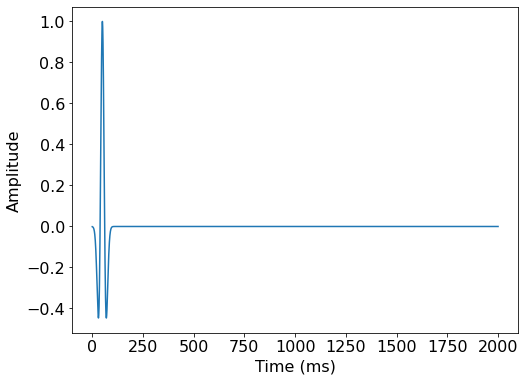

In [7]:
t0, tn = 0., 2000. # in ms
dt = 0.5
time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.02  

src = RickerSource(name='src', grid=model.grid, f0=f0, time_range=time_range)

# specify the source location
src.coordinates.data[:] = np.array([1200., 200., 100.]) #actuall place, NOT index
#NBVAL_SKIP

src.show()

In [10]:
v = VectorTimeFunction(name='v', grid=model.grid, space_order=so, time_order=to)
tau = TensorTimeFunction(name='t', grid=model.grid, space_order=so, time_order=to)


src_xx = src.inject(field=tau[0, 0].forward, expr=src*dt) ## why times "s" here? "s=model.grid.stepping_dim.spacing"
src_yy = src.inject(field=tau[1, 1].forward, expr=src*dt)
src_zz = src.inject(field=tau[2, 2].forward, expr=src*dt)

In [12]:
from sympy import Array, tensorproduct, Matrix, transpose, tensorcontraction
l, mu, ro = model.lam, model.mu, model.b

u_v_u = Eq(v.forward, model.damp * (v + dt*ro*div(tau)), subdomain = model.grid.subdomains['upper'])
u_t_u = Eq(tau.forward,  model.damp *  (tau + dt * (l * diag(div(v.forward)) +
                                                mu * (grad(v.forward) + grad(v.forward).T)))
           , subdomain = model.grid.subdomains['upper'])

# ------------------------------------------------------------------------------------------

elastic_3333_matrix = Array(elastic_3333_matrix)
strain = (grad(v.forward) + grad(v.forward).T) # e_kl
C_mul_strain = tensorproduct(elastic_3333_matrix, strain) #C_ijkl * e_kl = 6D_Matrix_ijklkl shape->(3,3,3,3,3,3)
first_contract = tensorcontraction(C_mul_strain,(3,4)) # shape-> (3,3,3,3)
sec_contract = tensorcontraction(first_contract,(2,3)) # shape-> (3,3)

u_v_l = Eq(v.forward,  model.damp * (v + dt*ro*div(tau)), subdomain = model.grid.subdomains['lower'])
u_t_l = Eq(tau.forward,  model.damp * (tau + dt * sec_contract),  subdomain = model.grid.subdomains['lower'])



In [15]:
op = Operator([u_v_u, u_v_l, u_t_u, u_t_l] + src_xx + src_yy + src_zz)

op.apply(time = 480)

Operator `Kernel` run in 50.87 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
  PerfEntry(time=50.847210999999994, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
 (PerfKey(name='section1', rank=None),
  PerfEntry(time=0.009960999999999984, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [16]:
np.array(v[0].data[0]).max()

0.006401969

In [17]:
v[0].data.shape

# the returned value means (t,x,y,z), (t+dt,x,y,z), (t+2dt,x,y,z), (t+3dt,x,y,z) if time order is three.

(3, 190, 340, 140)

In [19]:
scale =  1e-3

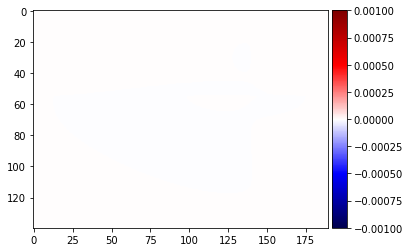

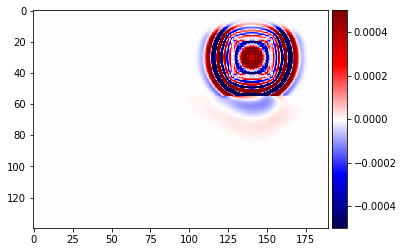

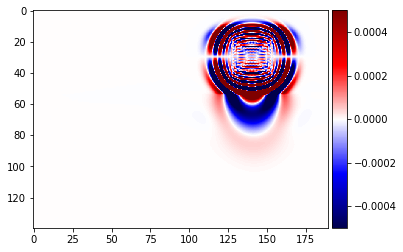

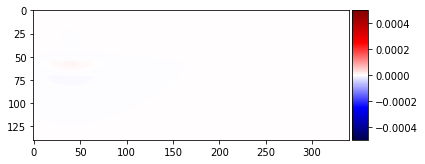

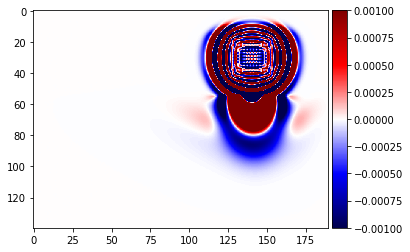

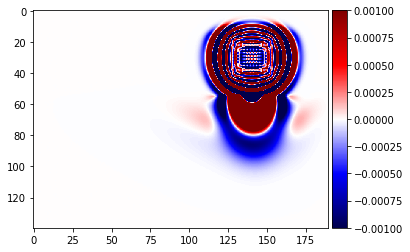

In [20]:
#NBVAL_IGNORE_OUTPUT

# Plots
%matplotlib inline

# Mid-points:
mid_x = int(0.5 * (v[0].data.shape[1]-1))
mid_y = int(0.5 * (v[0].data.shape[2]-1))
mid_z = int(0.5 * (v[0].data.shape[3]-1))


# # Plot some selected results:

plot_image(v[0].data[1, :, int(mid_y * 0.5), :],vmin = -scale, vmax = scale, cmap="seismic")
plot_image(v[1].data[1, :, int(mid_y * 0.2), :],vmin = -scale/2, vmax = scale/2, cmap="seismic")
plot_image(v[2].data[1, :, int(mid_y * 0.3), :],vmin = -scale/2, vmax = scale/2, cmap="seismic")
plot_image(v[0].data[1, mid_x, :, :], vmin = -scale/2, vmax = scale/2, cmap="seismic")

plot_image(tau[2, 2].data[1, :, int(mid_y * 0.3), :], vmin = -scale, vmax = scale, cmap="seismic")
plot_image(tau[2, 2].data[1, :, int(mid_y * 0.3), :], vmin = -scale, vmax = scale, cmap="seismic")
